In [1]:
# Print runtime spec
import os
import platform
import psutil
import subprocess

# CPU info
print("=== CPU Info ===")
print(f"Processor: {platform.processor()}")
print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical / {psutil.cpu_count()} logical")
cpu_freq = psutil.cpu_freq()
if cpu_freq:
    print(f"CPU Frequency: {cpu_freq.current:.2f} MHz")

# RAM info
print("\n=== RAM Info ===")
ram = psutil.virtual_memory()
print(f"Total RAM: {ram.total / (1024 ** 3):.2f} GB")
print(f"Available RAM: {ram.available / (1024 ** 3):.2f} GB")

# GPU info (NVIDIA)
print("\n=== GPU Info ===")
try:
    result = subprocess.run(
        ['nvidia-smi', '--query-gpu=name,memory.total,memory.used,driver_version', '--format=csv,noheader,nounits'],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True, text=True
    )
    gpus = result.stdout.strip().split('\n')
    for idx, gpu in enumerate(gpus):
        name, mem_total, mem_used, driver = [x.strip() for x in gpu.split(',')]
        print(f"GPU {idx}: {name}")
        print(f"  Total Memory: {mem_total} MB")
        print(f"  Used Memory: {mem_used} MB")
        print(f"  Driver Version: {driver}")
except FileNotFoundError:
    print("nvidia-smi not found. NVIDIA GPU may not be installed.")
except subprocess.CalledProcessError as e:
    print(f"Error running nvidia-smi: {e}")


=== CPU Info ===
Processor: x86_64
CPU Cores: 6 physical / 12 logical
CPU Frequency: 2200.21 MHz

=== RAM Info ===
Total RAM: 52.96 GB
Available RAM: 51.62 GB

=== GPU Info ===
GPU 0: NVIDIA L4
  Total Memory: 23034 MB
  Used Memory: 0 MB
  Driver Version: 550.54.15


# **Step 1. Setup the environment**

In [ ]:
%%capture
!pip install -q scanpy==1.9.6 # specific install <1.10.0 to use method = 'rapids'
!pip install -q anndata==0.10.7
!pip install -q leidenalg==0.10.2
!pip install -q numpy==1.26.4 # To avoid: AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.
!pip install google-cloud-storage


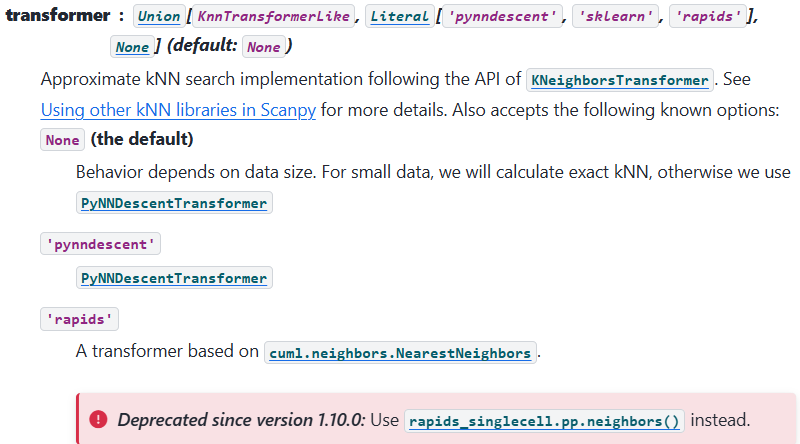

In [ ]:
import numpy as np
print(np.__version__)  # Should show 1.26.4
import pandas as pd
import os
os.environ["SCIPY_ARRAY_API"] = "1"
import sklearn # Avoid: RuntimeError: Scikit-learn array API support was enabled but scipy's own support is not enabled. Please set the SCIPY_ARRAY_API=1 environment variable before importing sklearn or scipy

import scanpy as sc
print(sc.__version__)  # Should show 1.9.6
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc_context

import time

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

1.26.4
1.9.6


Follow the instruction to allow access to google drive to save data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth # Authenticate your Colab environment to access your Google Cloud account.
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step 2. Load data and create a scanpy object**

In [3]:
# directly load from https://info.vizgen.com/protein-co-detection-showcase?submissionGuid=b2c89505-7fbc-453a-bbe0-0add9691c2fe
cell_by_gene_csv = 'gs://vz-ffpe-showcase/HumanUterineCancerPatient2-ROCostain/cell_by_gene.csv'
meta_cell_csv = 'gs://vz-ffpe-showcase/HumanUterineCancerPatient2-ROCostain/cell_metadata.csv'

In [4]:
def make_AnnData(cell_by_gene_path, meta_cell_path, frac, random_state): # downsize to fit ram

    cell_by_gene = pd.read_csv(cell_by_gene_path, index_col=0)
    cell_by_gene.index = [str(i) for i in cell_by_gene.index] # this ensure the cell IDs are strings
    cell_by_gene = cell_by_gene.sample(frac = frac, random_state= random_state)

    meta_cell = pd.read_csv(meta_cell_path, index_col=0)
    meta_cell.index = [str(i) for i in meta_cell.index] # this ensure the cell IDs are strings
    meta_cell = meta_cell.sample(frac = frac, random_state= random_state)

    meta_cell['barcodeCount'] = cell_by_gene.sum(axis=1)

    # initialize meta_gene
    meta_gene = pd.DataFrame(index=cell_by_gene.columns.tolist())

    # Align the cell id of cell_by_gene and cell_metadata
    cell_id = cell_by_gene.index.tolist()
    meta_cell = meta_cell.loc[cell_id]

    coordinates =np.stack((meta_cell['center_x'], meta_cell['center_y']), axis=1)

    ad = sc.AnnData(X=cell_by_gene.values, obs=meta_cell, var=meta_gene, obsm={"spatial": coordinates})
    return ad

In [5]:
adata = make_AnnData(cell_by_gene_csv, meta_cell_csv, frac = 0.1, random_state=1128)
# Filtering out blank genes
adata = adata[:, adata.var_names.str.startswith('Blank-')==False]

# Storing the counts for later use
adata.layers["counts"] = adata.X.copy()

adata

/tmp/ipython-input-5-2845559104.py:6: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


AnnData object with n_obs × n_vars = 75851 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Anti-Ms-CD45RO_raw', 'Anti-Ms-CD45RO_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'barcodeCount'
    obsm: 'spatial'
    layers: 'counts'

# **Step 3. Single cell anaysis**

In [6]:
data_processing_start = time.time()

In [7]:
%%time

# set the threshold
min_barcode_count_threshold = 20
volume_upper_threshold = 2500
volume_lower_threshold = 100

selectCells = adata.obs[(adata.obs.volume < volume_upper_threshold)
                   & (adata.obs.volume > volume_lower_threshold)
                   & (adata.obs.barcodeCount > min_barcode_count_threshold)].index

adata = adata[selectCells].copy()

# Normalize barcode counts by cell volume
adata.obs['volume_factor'] = adata.obs['volume']/np.median(adata.obs['volume'])
adata.X = np.divide(adata.X, np.array(adata.obs['volume_factor']).reshape(-1, 1))

CPU times: user 430 ms, sys: 106 ms, total: 535 ms
Wall time: 532 ms


In [8]:
%%time

# Normalize barcode counts by total counts over all genes and log transform data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Store raw data in the .raw attribute before scaling
adata.raw = adata.copy()

# scale gene counts
sc.pp.scale(adata, max_value=10)

# PCA
# sc.tl.pca(adata, svd_solver='arpack')
sc.tl.pca(adata, svd_solver = 'auto') # svd_solver setting follows rapids_singlecell.pp.pca
# sc.pl.pca_variance_ratio(adata, log=True) # use elbow plot to determine the number of PCs

# Connect neighbors and embed in UMAP
sc.pp.neighbors(adata, method='rapids') ## use transformer = 'rapids' to match rapids-singlecell workflow
sc.tl.umap(adata)

# Cluster cells using the Leiden algorithm
sc.tl.leiden(adata, resolution=1.5)


normalizing counts per cell
    finished (0:00:00)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:03)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:09)
CPU times: user 4min 20s, sys: 4.24 s, total: 4min 24s
Wall time: 3min 40s


# Rank genes (Differential expression)

ranking genes


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

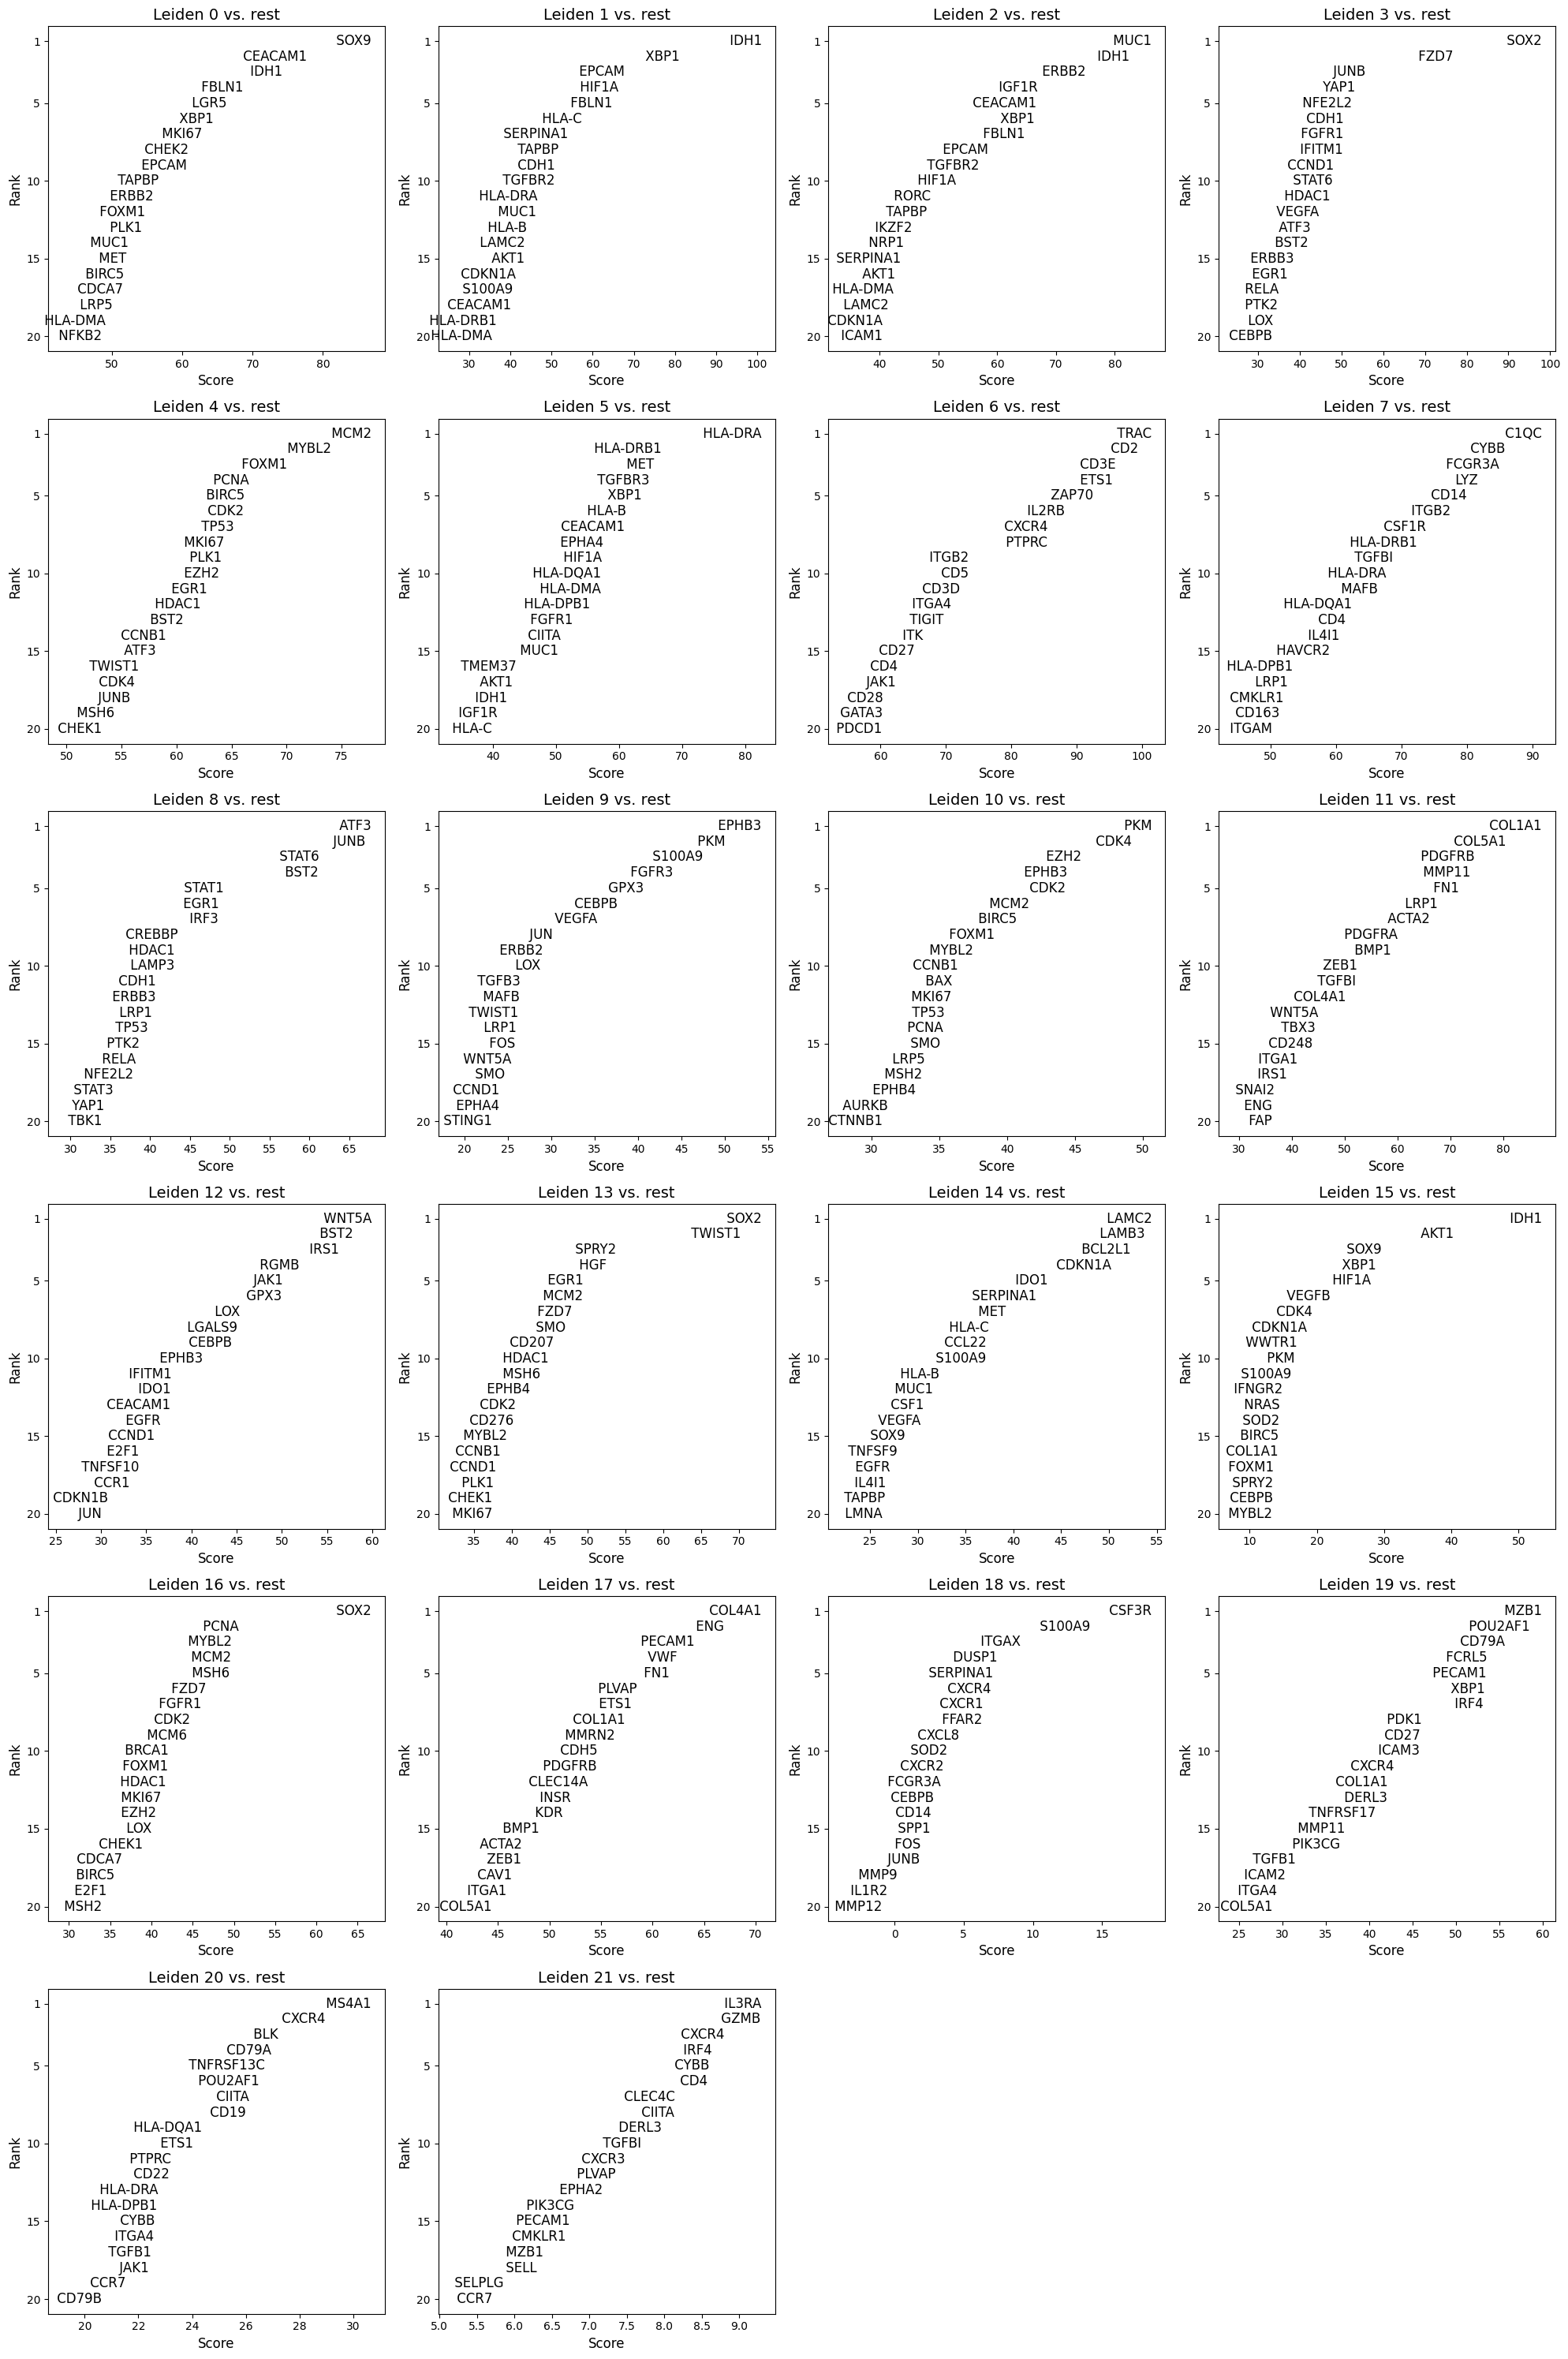

CPU times: user 12.9 s, sys: 1.41 s, total: 14.3 s
Wall time: 13.9 s


In [9]:
%%time

# Rank genes (Differential expression)
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
# sc.pl.rank_genes_groups(adata, n_genes=20, fontsize=12, ncols=3, sharey=False)

# Plot gene rank
# swop x and y axis to make gene names in horizontal for better visualization

# Number of clusters
n_clusters = len(adata.obs['leiden'].unique())
n_rows = 6
n_cols = 4
n_genes = 20  # Number of genes to visualize

# Define subplot size
subplot_width = 5  # Width of each subplot
subplot_height = 5  # Height of each subplot

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * subplot_width, n_rows * subplot_height))
axes = axes.flatten()  # Flatten the grid to iterate easily

# Loop over each Leiden cluster
for i in range(n_clusters):
    group = str(i)  # Leiden cluster name as a string
    ax = axes[i]  # Select the corresponding subplot

    # Extract rank genes information
    genes = adata.uns['rank_genes_groups']['names'][group][:n_genes]
    scores = adata.uns['rank_genes_groups']['scores'][group][:n_genes]

    # Creating a DataFrame for ease of plotting
    data = pd.DataFrame({'Rank': range(1, n_genes + 1), 'Gene': genes, 'Score': scores})

    # Plotting on the subplot
    ax.scatter(data['Score'], data['Rank'], color='blue', s=0)  # Make dots invisible by setting size to 0
    ax.invert_yaxis()  # Invert y-axis to have rank 1 at the top

    # Adding gene name labels next to dots
    for j, row in data.iterrows():
        ax.text(row['Score'], row['Rank'], f" {row['Gene']}", va='center', ha='right', fontsize=12)

    # Adjusting y-axis to show only specific ranks
    ax.set_yticks([1, 5, 10, 15, 20])
    ax.set_yticklabels([1, 5, 10, 15, 20])
    ax.tick_params(axis='x', labelsize=10)  # Adjust x-axis tick size
    ax.tick_params(axis='y', labelsize=10)  # Adjust y-axis tick size

    # Adjusting x-axis min
    xmin = data['Score'].min() - (data['Score'].max()-data['Score'].min())*.2
    ax.set_xlim(xmin, None)  # Set xmin, leaving xmax as automatic

    # Formatting the subplot
    ax.set_title(f'Leiden {group} vs. rest', fontsize=14)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('Rank', fontsize=12)

# Leave the last subplot blank
for i in range(n_clusters, len(axes)):
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# Plot ranking of genes using dotplot




/usr/local/lib/python3.11/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/usr/local/lib/python3.11/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/usr/local/lib/python3.11/dist-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementatio

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


/usr/local/lib/python3.11/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/usr/local/lib/python3.11/dist-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

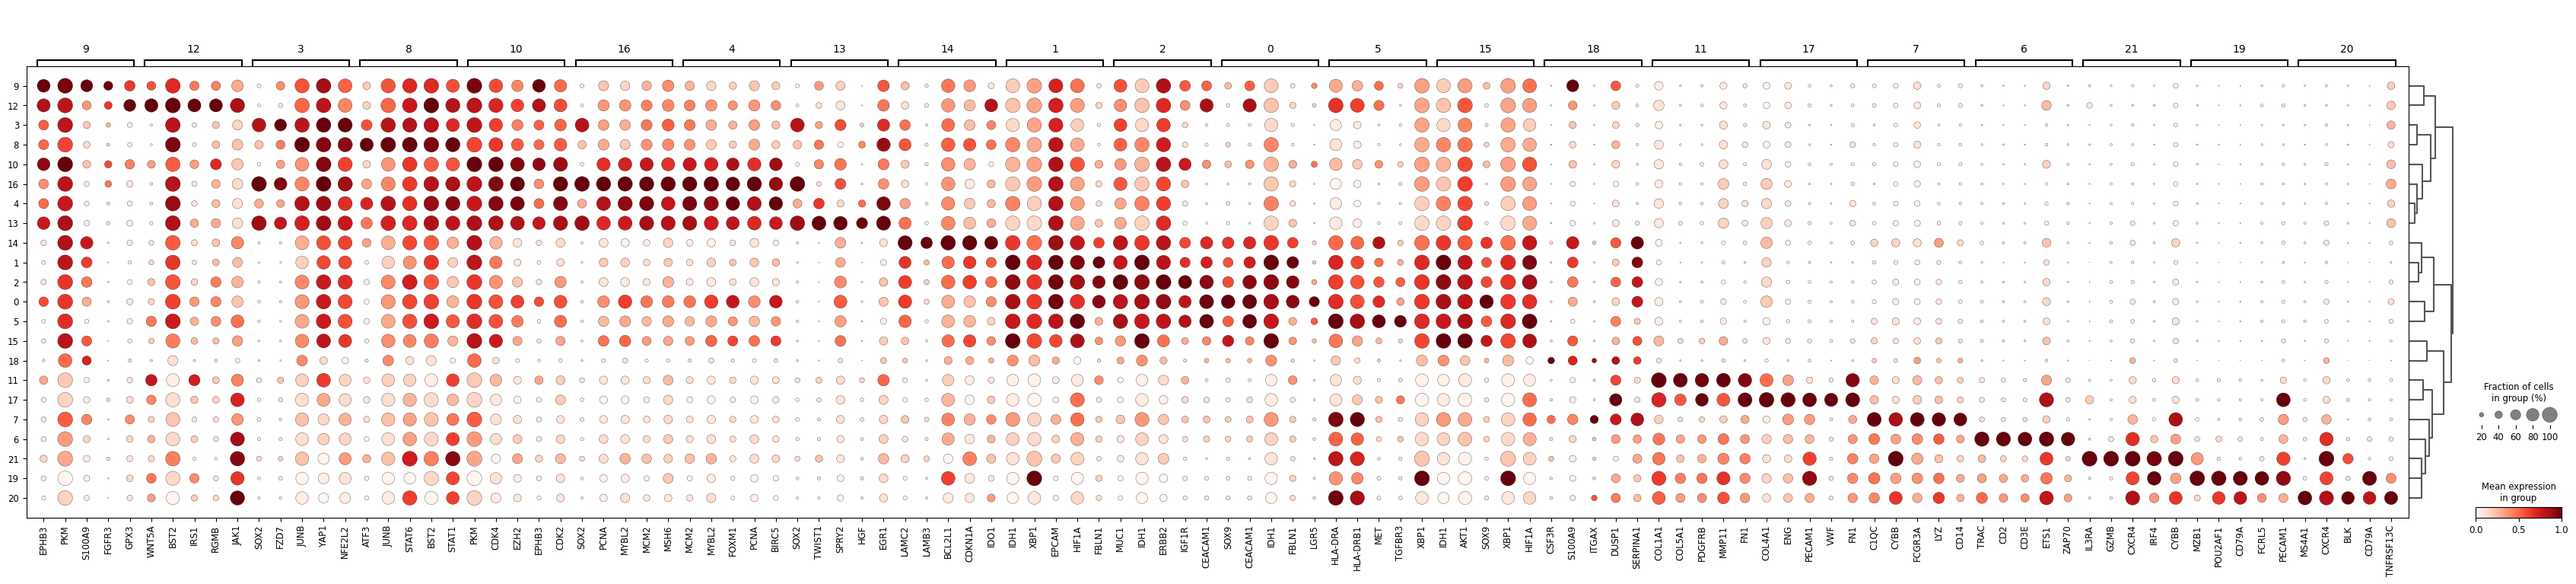

In [10]:
sc.pl.rank_genes_groups_dotplot(adata, groupby='leiden',n_genes=5, standard_scale='var')

In [11]:
data_processing_time = time.time()
elapsed_seconds = data_processing_time - data_processing_start
elapsed_minutes = elapsed_seconds / 60

print("Total data processing time: %.2f minutes" % elapsed_minutes)


Total data processing time: 3.95 minutes


# **Step 4. Visualize clusters on UMAP and spatial distribution**

/usr/local/lib/python3.11/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


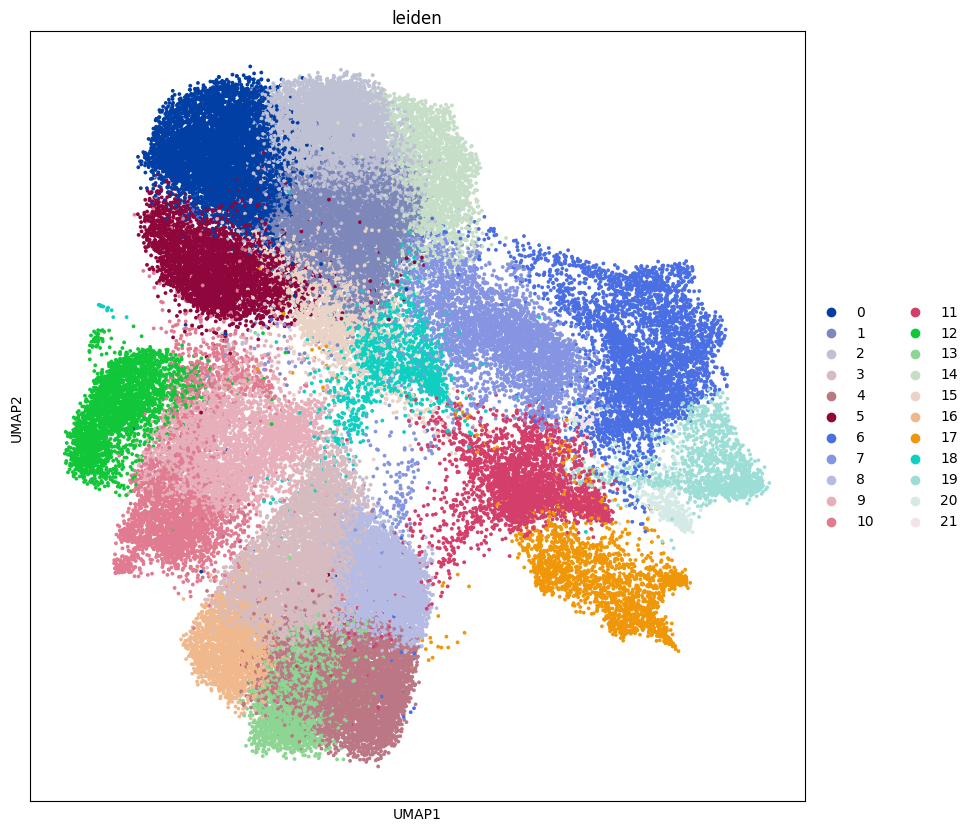

/usr/local/lib/python3.11/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


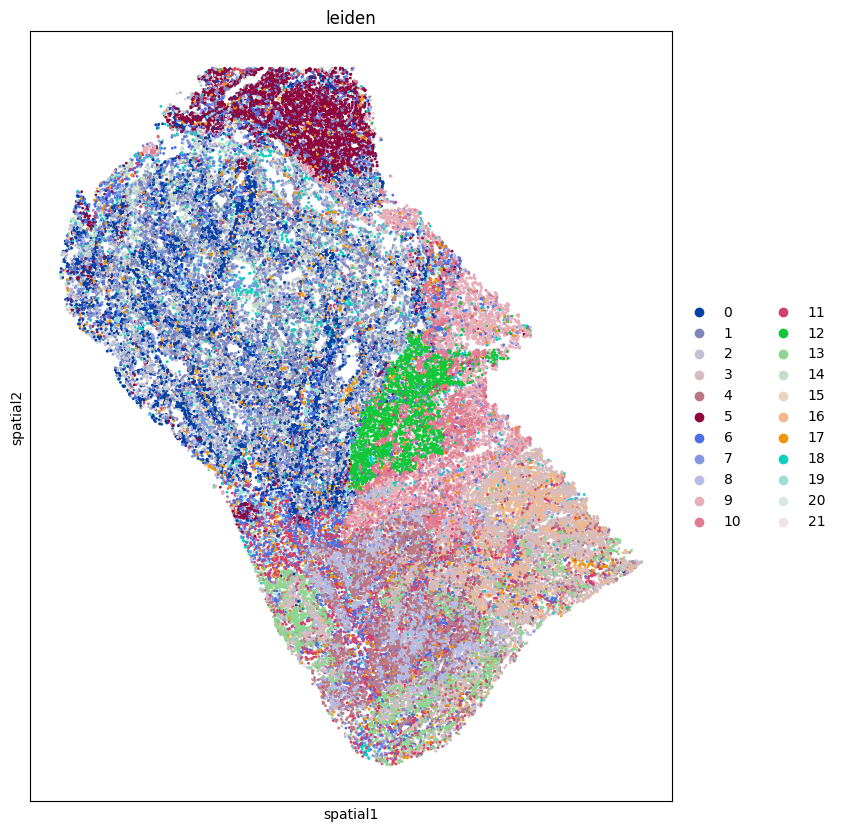

In [12]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color="leiden", size= 30, alpha = 1)

with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(adata, color='leiden', spot_size=50, alpha = 1)

In [19]:
# print out session information
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.9.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.14
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
anndata                               0.10.7
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array-api-compat                      1.12.0
array_record                          0.7.2
arviz 